# Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np
import cv2
from functools import partial

In [4]:
from am.logger import init_logger
from am.register import *
from am.register.rotation import *
from am.register.clustering import *
from am.register.visual import *
from am.register.image_processing import *

In [5]:
import logging
if not logging.getLogger('am-segm').handlers:
    init_logger()
logger = logging.getLogger('am-segm')

# Load Data

In [354]:
def load_source_mask(source_path, mask_path):
    source = cv2.imread(str(source_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    h, w = source.shape
    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
    return source, mask

In [355]:
data_path = Path('data/Mouse16_PFA_SlideN_left')
group = 'Well5'
source_path = Path(data_path / 'source_norm' / group / 'source.tiff')
mask_path = Path(data_path / 'tiles_stitched' / group / 'mask.tiff')

In [356]:
row_offset, col_offset, patch_size = 100, 200, 1500
cut = partial(cut_patch, y_offset=row_offset, x_offset=col_offset, patch=patch_size)

# Rotate Mask

In [357]:
source, mask = load_source_mask(source_path, mask_path)
source.shape, mask.shape

((12763, 8219), (12763, 8219))

In [358]:
target_axis = 1  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)

In [359]:
best_angle = optimal_mask_rotation(mask, target_axis, angle_range=2, angle_step=0.1)
# best_angle = 0.800
best_angle

2020-01-15 13:55:14,583 - am-segm - INFO - Optimizing mask rotation, angle range=2 with step=0.1
2020-01-15 13:55:29,618 - am-segm - INFO - Target axis: 1, best angle: 0.900, best proj 0.565
2020-01-15 13:55:29,620 - am-segm - INFO - Function 'optimal_mask_rotation' running time: 0m 15s


0.9000000000000026

In [360]:
mask = rotate_image(mask, best_angle, binarize=True)
source = rotate_image(source, best_angle, binarize=False)

(<Figure size 1600x1000 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f57ec030be0>)

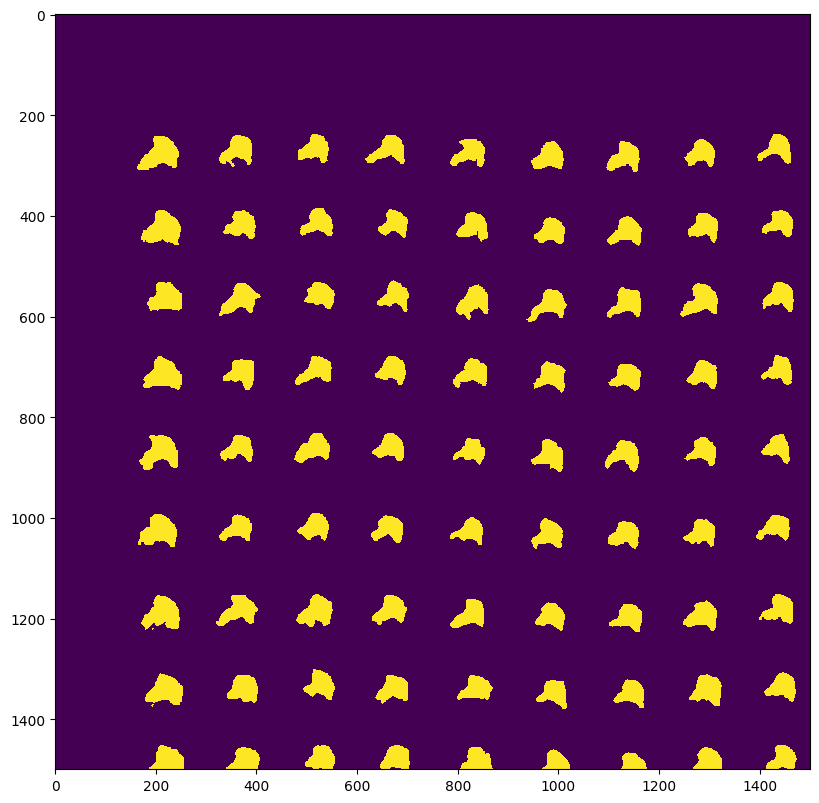

In [361]:
plot_image(cut(mask))

# Estimate Acquisition Grid

In [362]:
from am.register.acq_grid_estimation import estimate_acq_grid_shape
from am.register.visual import plot_coord_peaks

In [363]:
acq_grid_shape = estimate_acq_grid_shape(mask)
acq_grid_shape

(80, 49)

In [364]:
mask_sparse = sparse.coo_matrix(mask)

In [365]:
x_hist, x_peaks, x_half_avg_height = find_coord_peaks(mask_sparse.col)
x_peaks.shape[0]

49

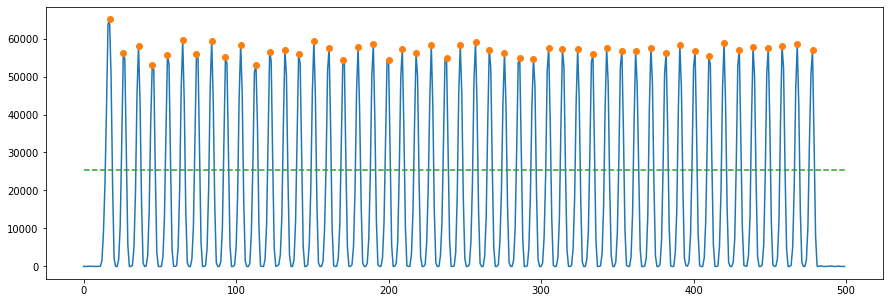

In [366]:
plot_coord_peaks(x_hist, x_peaks, x_half_avg_height)

In [367]:
y_hist, y_peaks, y_half_avg_height = find_coord_peaks(mask_sparse.row)
y_peaks.shape[0]

80

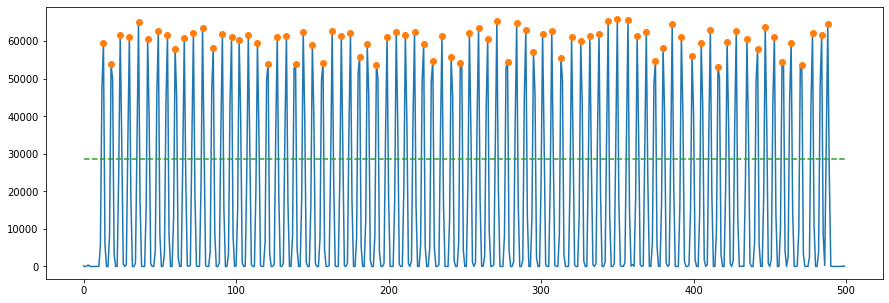

In [368]:
plot_coord_peaks(y_hist, y_peaks, y_half_avg_height)

# Clean Mask and Find Centers

2020-01-15 13:56:19,591 - am-segm - INFO - Applying erosion and dilation


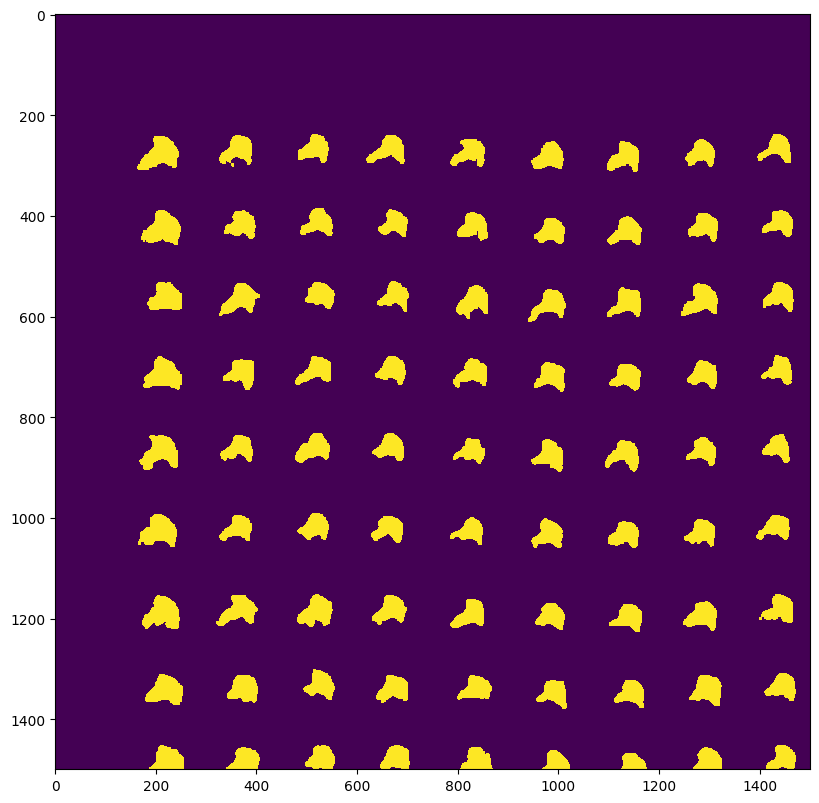

In [369]:
mask = erode_dilate(mask)
plot_image(cut(mask));

2020-01-15 13:56:20,206 - am-segm - INFO - Removing noisy ablation marks
2020-01-15 13:56:20,271 - am-segm - INFO - axis=0, min=344, max=12465
2020-01-15 13:56:20,364 - am-segm - INFO - axis=1, min=382, max=7812


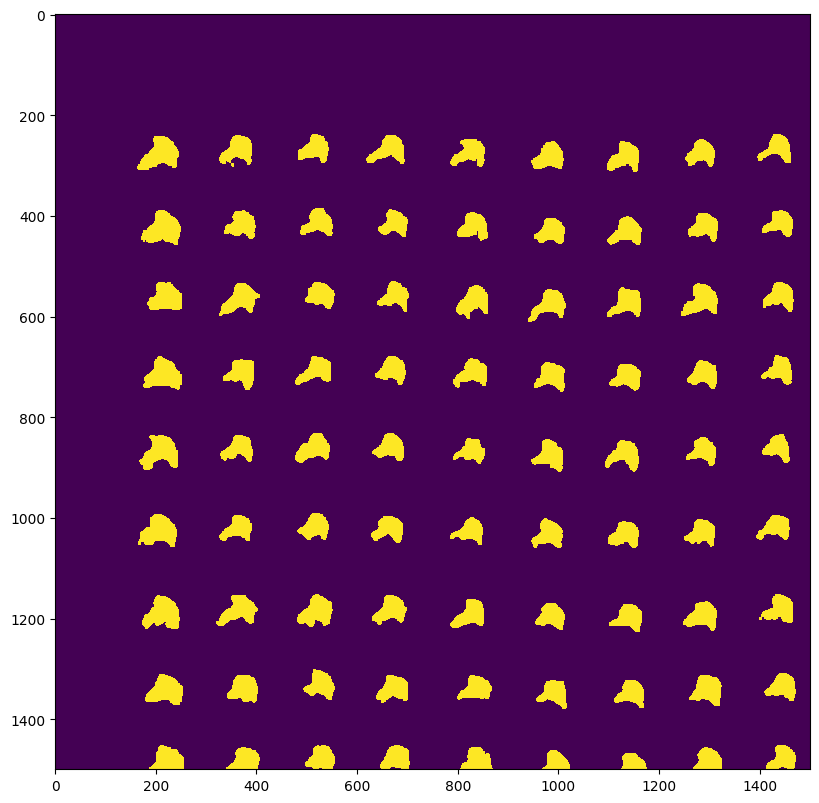

In [370]:
mask = remove_noisy_marks(mask, acq_grid_shape)
plot_image(cut(mask));

In [371]:
am_centers = find_am_centers(mask)
len(am_centers)

2020-01-15 13:56:20,880 - am-segm - INFO - Finding AM centers


3994

In [372]:
# am_centers = am_centers[row_mask & col_mask]
# am_centers.shape
# min_max(am_centers[:,0]), min_max(am_centers[:,1])

In [373]:
row_offset, col_offset, patch_size

(100, 200, 1500)

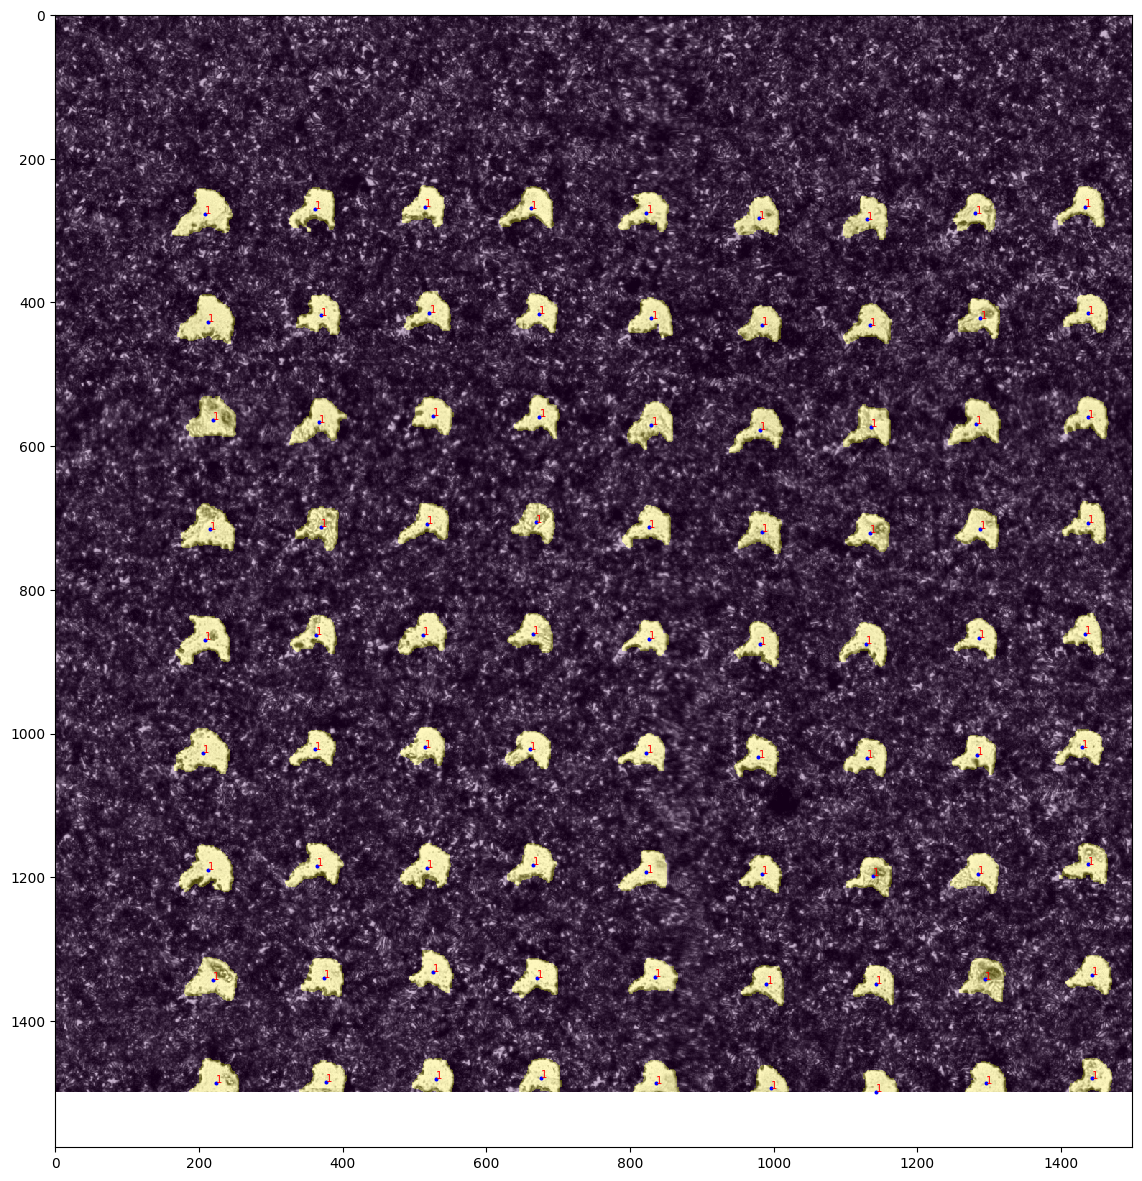

In [374]:
labels = np.ones(am_centers.shape[0], dtype=int)
plot_am_labels(mask, am_centers, labels, source, row_offset, col_offset, patch_size)

# Cluster AM Centers

In [375]:
am_centers.shape

(3994, 2)

In [376]:
target_axis = 0  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

80

In [377]:
y_labels = cluster_coords(am_centers[:,target_axis], acq_grid_shape[target_axis], sample_ratio=1)

2020-01-15 13:56:44,616 - am-segm - INFO - Clustering (3994,) array into 80 clusters


In [378]:
y_axis_coords = am_centers[:,target_axis]

In [379]:
target_axis = 1  # target axis: (1 = columns = X-axis, 0 = rows = Y-axis)
acq_grid_shape[target_axis]

49

In [380]:
x_labels = cluster_coords(am_centers[:,target_axis], acq_grid_shape[target_axis], sample_ratio=1)

2020-01-15 13:56:46,113 - am-segm - INFO - Clustering (3994,) array into 49 clusters


In [381]:
x_axis_coords = am_centers[:,target_axis]

In [382]:
x_axis_coords.shape, x_labels.shape

((3994,), (3994,))

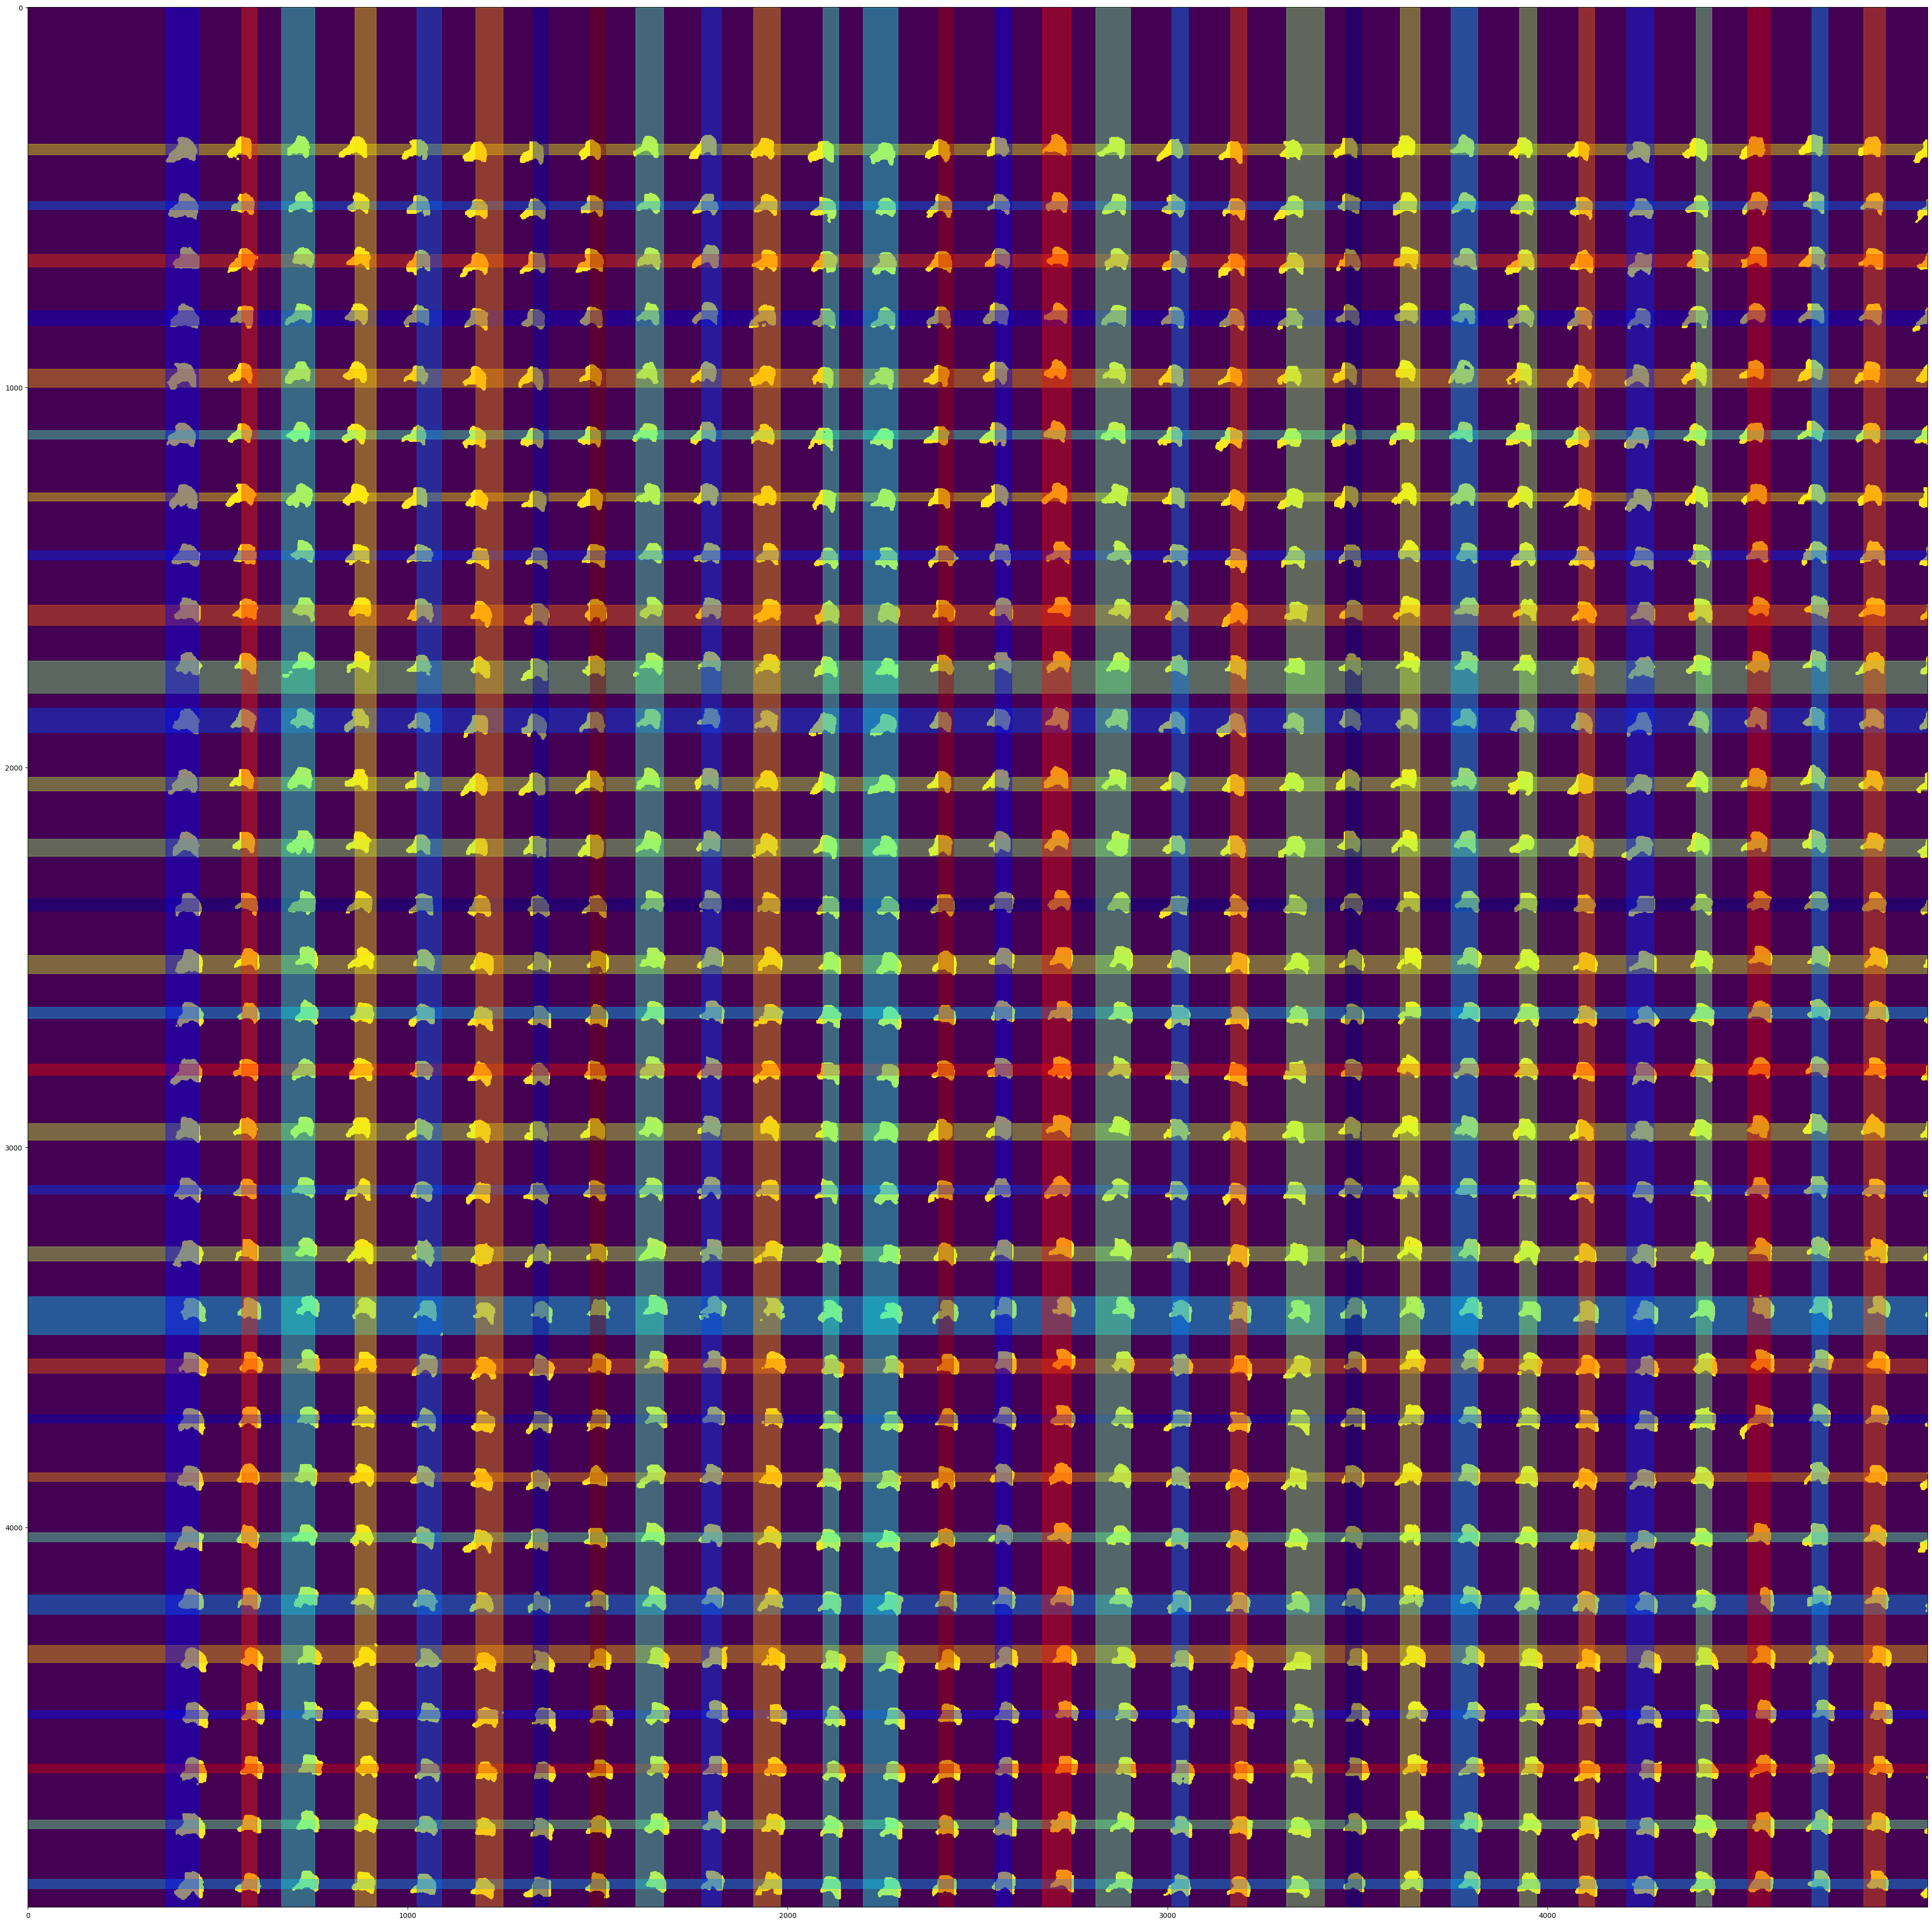

In [383]:
patch = cut_patch(mask, y_offset=0, x_offset=0, patch=5000)
h, w = patch.shape
fig, ax = plot_image(patch, figsize=(w/100, h/100))
plot_labels(ax, patch, 0, y_axis_coords, y_labels, set(y_labels))
plot_labels(ax, patch, 1, x_axis_coords, x_labels, set(x_labels))
# plt.savefig('/tmp/image.png', bbox_inches='tight')
# plt.close()

In [384]:
acq_y_grid = convert_labels_to_grid(y_axis_coords, y_labels)
acq_x_grid = convert_labels_to_grid(x_axis_coords, x_labels)
acq_indices = convert_grid_to_indices(acq_y_grid, acq_x_grid, acq_grid_shape[1])

2020-01-15 13:57:17,214 - am-segm - INFO - Converting labels to grid values
2020-01-15 13:57:17,217 - am-segm - INFO - Converting labels to grid values
2020-01-15 13:57:17,219 - am-segm - INFO - Converting grid values to indices


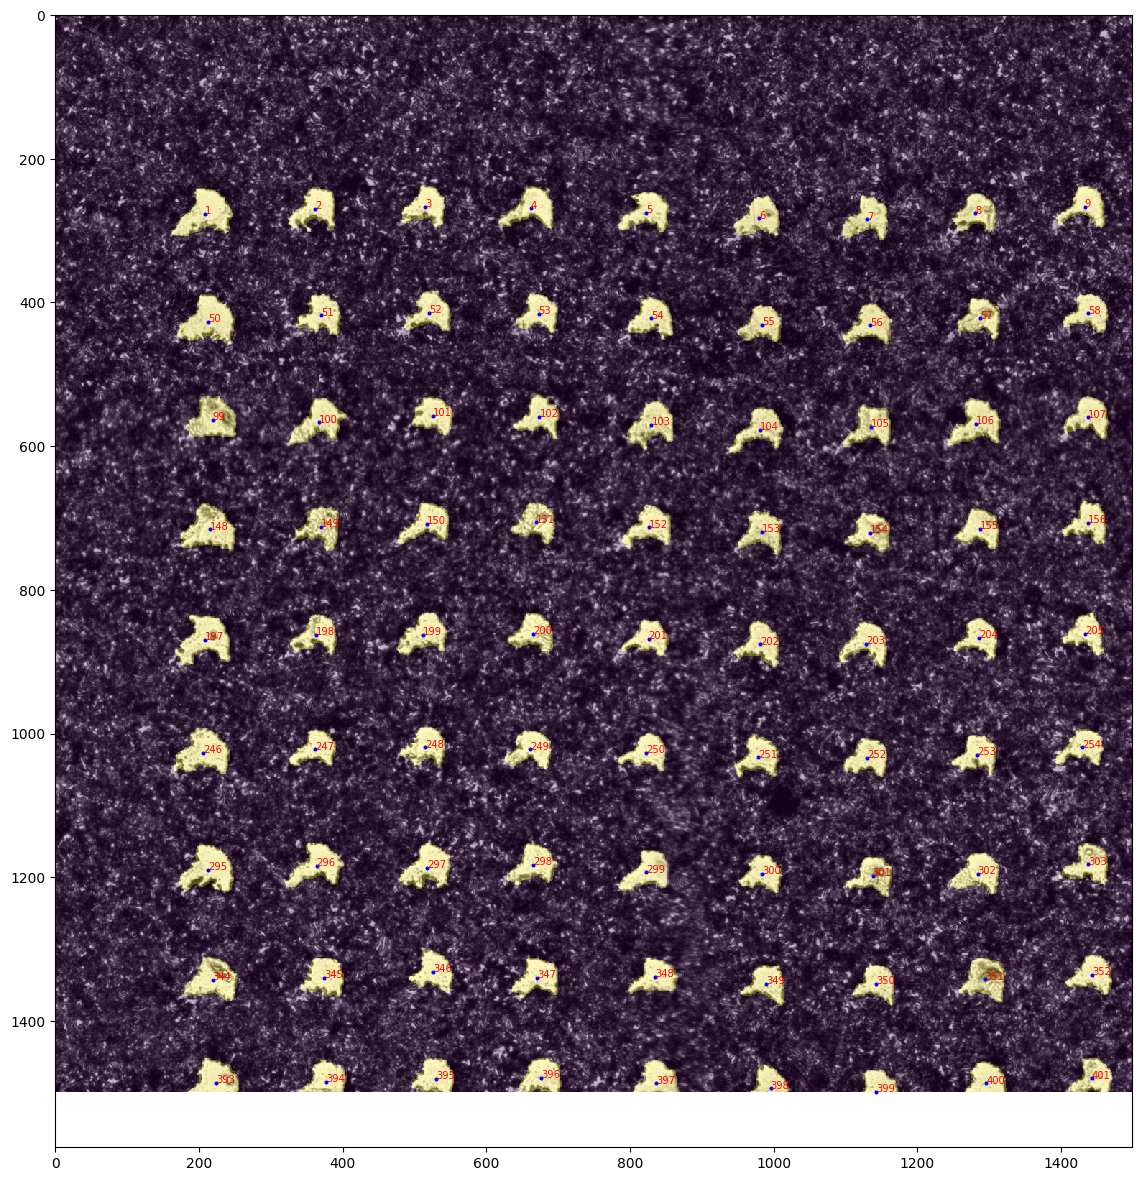

In [385]:
plot_am_labels(mask, am_centers, acq_indices, source, row_offset, col_offset, patch_size)

# Rotate Image and AM Centers Back

In [319]:
best_angle

0.9000000000000026

In [320]:
mask = rotate_image(mask, -best_angle, binarize=True)
source = rotate_image(source, -best_angle, binarize=False)

In [321]:
# plot_image(cut_patch(image))

In [322]:
am_centers = rotate_am_centers(am_centers, -best_angle, mask.shape)
# am_centers

2020-01-15 13:45:56,381 - am-segm - INFO - Rotating AM centers on -0.900 angle


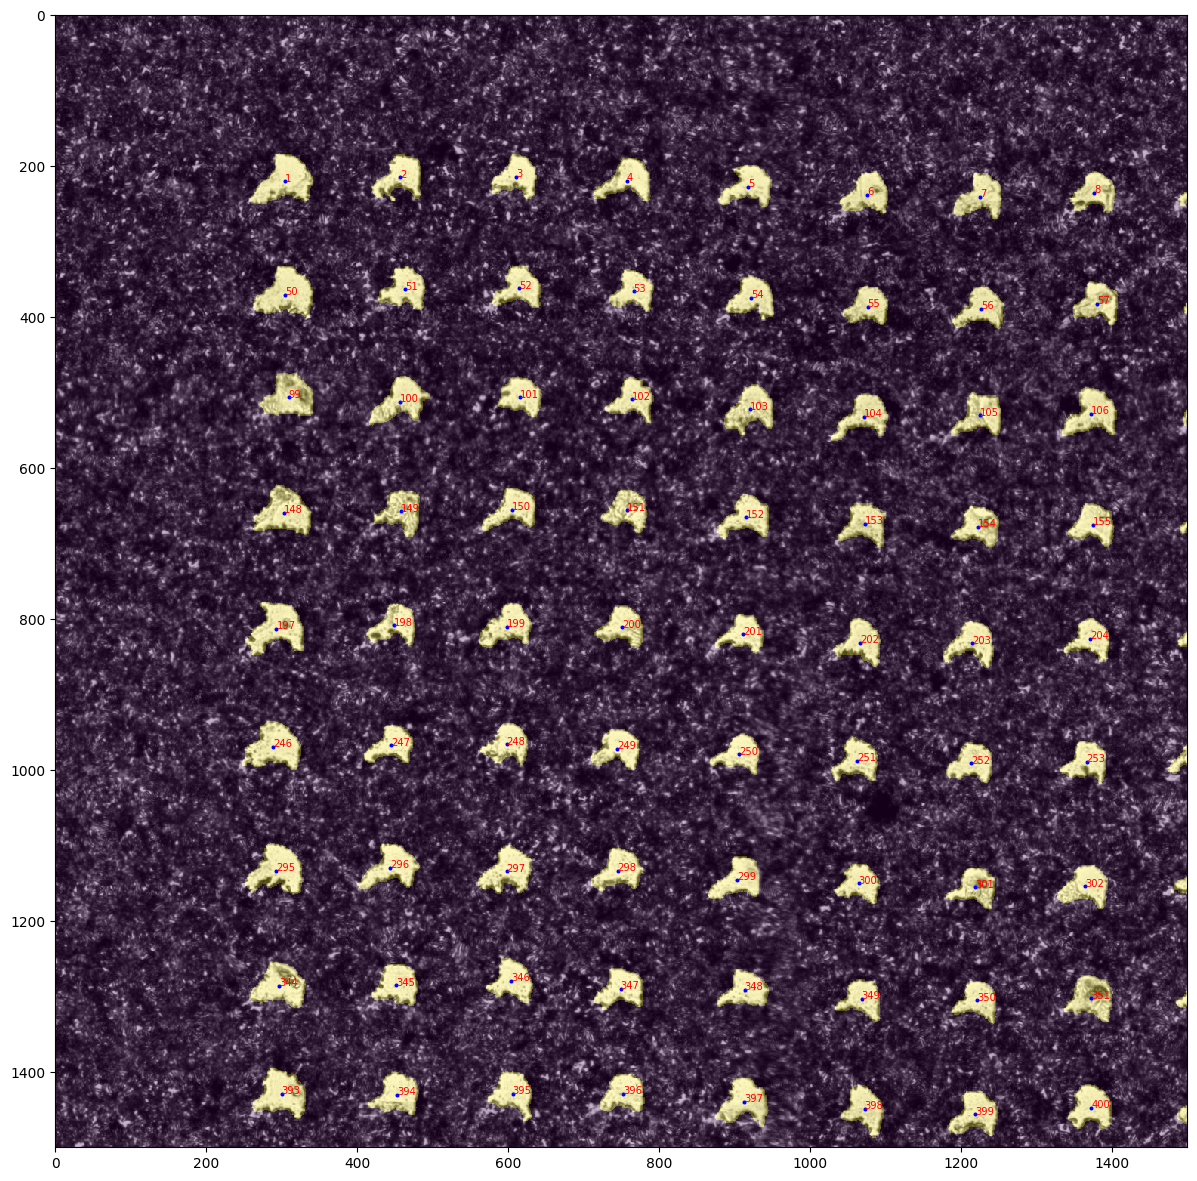

In [323]:
plot_am_labels(mask, am_centers, acq_indices, source, row_offset, col_offset, patch_size)

# Fill Mask with Acqusition Indices

In [138]:
acq_indices.shape

(3944,)

In [140]:
acq_index_mask_coo = create_acq_index_mask(mask, am_centers, acq_indices)

2019-10-02 11:52:59,045 - am-segm - INFO - Creating acquisition index mask


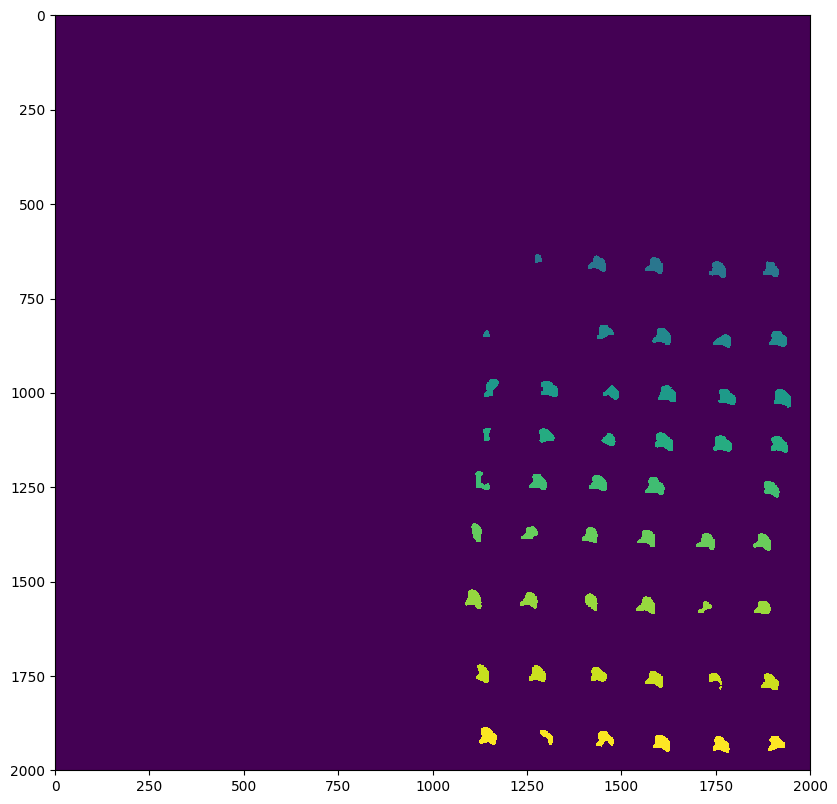

In [141]:
img = acq_index_mask_coo.toarray()
img[img == 0] = -255  # to make the first row with small marker values visible
plot_image(cut(img));

In [142]:
row_offset, col_offset, patch_size

(0, 0, 2000)

In [144]:
mask.shape, acq_grid_shape

((13400, 8911), (80, 50))

In [145]:
plot_am_labels(
    mask=mask, centers=am_centers, labels=acq_indices, source=source,
#     row_offset=row_offset, col_offset=col_offset, patch_size=1000
);
plt.axis('off')
plt.savefig(
    '/tmp/image.png',
    bbox_inches='tight',
)
plt.close()

In [177]:
# import matplotlib.pyplot as plt

# for dpi in [72,100,144]:

#     fig,ax = plt.subplots(figsize=(1.5,2), dpi=dpi)
#     ax.set_title("fig.dpi={}".format(dpi))

#     ax.set_ylim(-3,3)
#     ax.set_xlim(-2,2)

#     ax.scatter([0],[1], s=10**2, 
#                marker="s", linewidth=0, label="100 points^2")
#     ax.scatter([1],[1], s=(10*72./fig.dpi)**2, 
#                marker="s", linewidth=0, label="100 pixels^2")

#     ax.legend(loc=8, framealpha=1, fontsize=8)

#     fig.savefig("fig{}.png".format(dpi), bbox_inches="tight")

# plt.show() 

# Convert and Save Results

In [136]:
import operator

In [137]:
%%time
am_x_y_coords = []
for acq_idx in range(1, operator.mul(*acq_grid_shape) + 1):
    pixel_inds = (markers_coo.data == acq_idx).nonzero()[0]
    ys = markers_coo.row[pixel_inds]
    xs = markers_coo.col[pixel_inds]
    am_x_y_coords.append([xs, ys])

CPU times: user 26.7 s, sys: 73.5 ms, total: 26.8 s
Wall time: 26.8 s


In [138]:
np.save('marks_mask.npy', am_x_y_coords)

In [139]:
am_x_y_coords = np.load('marks_mask.npy')

In [140]:
am_x_y_coords[0]

array([array([185, 186, 187, ..., 204, 205, 206], dtype=int32),
       array([269, 269, 269, ..., 311, 311, 311], dtype=int32)],
      dtype=object)

In [141]:
m = np.zeros_like(markers)
for idx, (xs, ys) in enumerate(am_x_y_coords, 1):
    m[ys, xs] = idx

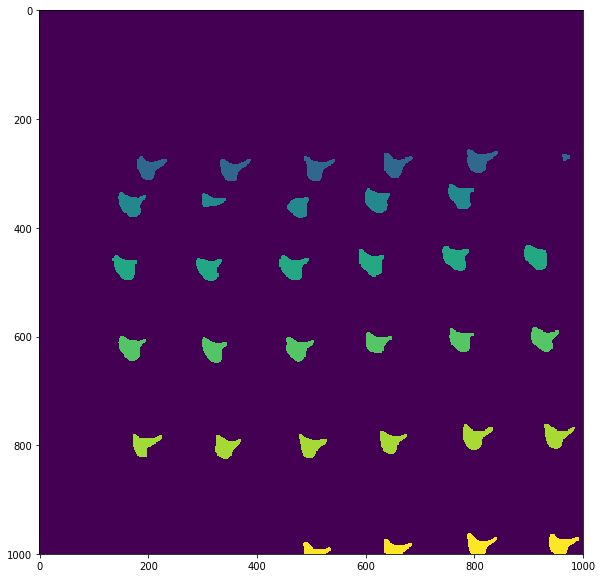

In [142]:
m[m == 0] = -255
plot_image(cut_patch(m))

In [335]:
# a = np.load('data/test_AM_image/marksMask.npy')
# a.shape
# xs, ys, = a[0]
# xs.shape, ys.shape
# xs